In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd

animes_file_path = '/content/drive/MyDrive/Anime_Data/archive_2/animes.csv'
try:
  df_animes = pd.read_csv(animes_file_path)
except FileNotFoundError:
  print(f"Error: File not found at {animes_file_path}")

#Preprocessing and Feature Engineering

In [ ]:
df_animes = df_animes.drop(columns=['synopsis', 'img_url', 'link'], errors='ignore')

In [ ]:
columns_to_check = ['uid', 'title', 'genre', 'aired', 'episodes', 'score']
df_animes_deduplicated = df_animes.drop_duplicates(subset=columns_to_check, keep='first').reset_index(drop=True)

df_animes = df_animes_deduplicated

In [ ]:
rows_to_remove = df_animes[
    (df_animes['aired'] == "Not available") &
    ((df_animes['episodes'].isnull()) | (df_animes['episodes'].isna())) &
    ((df_animes['score'].isnull()) | (df_animes['score'].isna()))
]

df_animes = df_animes.drop(rows_to_remove.index)

df_animes = df_animes.reset_index(drop=True)

In [ ]:
df_animes.shape

(16113, 9)

In [ ]:
def categorize_episodes(episodes):
    if episodes <= 12:
        return "1-12"
    elif episodes <= 26:
        return "13-26"
    elif episodes <= 60:
        return "27-60"
    elif episodes <= 100:
        return "61-100"
    elif episodes <= 300:
        return "101-300"
    elif episodes > 300:
        return "301+"
    elif episodes is None:
        return "Unknown"
    else:
        return "Unknown"

df_animes['episode_category'] = df_animes['episodes'].apply(categorize_episodes)

In [ ]:
def categorize_title(row):
    title = row['title']
    episodes = row['episodes']
    aired = row['aired']

    if "movie" in title.lower() and "special" in title.lower():
        return "Movie/Special"
    elif "movie" in title.lower() and episodes == 1:
        return "Movie"
    elif "special" in title.lower():
        return "Special"
    elif "ona" in title.lower() or "ova" in title.lower():
        return "Special"
    elif "season" in title.lower():
        return "Series"
    elif "tv" in title.lower():
        return "Series"
    elif "?" in aired:
        return "Series"
    elif pd.notna(aired) and 'to' not in aired and episodes == 1:
        return "Movie"
    elif pd.notna(aired) and 'to' in aired and episodes > 1:
        return "Series"
    elif pd.notna(aired) and 'to' not in aired and episodes > 8:
        return "Series"
    elif pd.notna(aired) and 'to' not in aired and episodes <= 8:
        return "Short Series"
    else:
        return "Other"

df_animes['title_category'] = df_animes.apply(categorize_title, axis=1)

In [ ]:
def extract_year(aired_string):
    try:
        if pd.isna(aired_string):
          return None

        if 'to' in aired_string:
            parts = aired_string.split(' to ')
            if len(parts) > 0 and parts[0].strip():
              year_str = parts[0].strip().split(',')[-1].strip()
              if year_str.isdigit():
                return int(year_str)
        elif '-' in aired_string:
            parts = aired_string.split('-')
            if len(parts) > 0:
              year_str = parts[0].strip()
              if year_str.isdigit():
                return int(year_str)

        year_str = aired_string.split(',')[-1].strip()
        if year_str.isdigit():
            return int(year_str)

        return None

    except (IndexError, ValueError, AttributeError):
        return None


def categorize_year(year):
    if pd.isna(year):
        return "Unknown"
    elif year <= 1950:
        return "<=1950"
    else:
        decade_start = (int(year) // 10) * 10
        return f"{decade_start}s"


df_animes['aired_year'] = df_animes['aired'].apply(extract_year)
df_animes['aired_decade'] = df_animes['aired_year'].apply(categorize_year)

In [ ]:
df_animes_remove_rows = df_animes[
    ((df_animes['title_category'] == "Other") |
     (df_animes['episode_category'] == "Unknown") |
      (df_animes['aired_decade'] == "Unknown"))
]

df_animes = df_animes.drop(df_animes_remove_rows.index)

df_animes = df_animes.reset_index(drop=True)

In [ ]:
df_animes.shape

(15546, 13)

In [ ]:
def encode_title_category(title_category):
    categories = ['Movie', 'Series', 'Movie/Special', 'Special', 'Short Series']
    encoded = [1 if title_category == cat else 0 for cat in categories]
    return encoded

def encode_aired_half_decade(aired_half_decade):
    categories = ["<=1950","1950s","1960s","1970s","1980s","1990s","2000s","2010s","2020s"]
    encoded = [1 if aired_half_decade == cat else 0 for cat in categories]
    return encoded

def encode_episode_category(episode_category):
    categories = ['1-12','13-26','27-60','61-100','101-300','301+']
    encoded = [1 if episode_category == cat else 0 for cat in categories]
    return encoded

def encode_genres(genres, unique_genres):
    encoded = [1 if genre in genres else 0 for genre in unique_genres]
    return encoded

unique_genres = ['Thriller', 'Horror', 'Shounen', 'Samurai', 'Supernatural', 'Psychological',
                 'Hentai', 'Cars', 'Dementia', 'Mecha', 'Ecchi', 'Mystery', 'Romance', 'Demons',
                 'School', 'Martial Arts', 'Seinen', 'Shoujo Ai', 'Music', 'Vampire', 'Game',
                 'Shounen Ai', 'Comedy', 'Magic', 'Space', 'Kids', 'Police', 'Harem', 'Adventure',
                 'Yaoi', 'Drama', 'Historical', 'Sci-Fi', 'Military', 'Shoujo', 'Slice of Life',
                 'Parody', 'Super Power', 'Yuri', 'Fantasy', 'Josei', 'Action', 'Sports']


df_animes['genres_encoded'] = df_animes['genre'].apply(lambda x: encode_genres(x, unique_genres))
df_animes['encoded_title_category'] = df_animes['title_category'].apply(encode_title_category)
df_animes['encoded_aired_decade'] = df_animes['aired_decade'].apply(encode_aired_half_decade)
df_animes['encoded_episodes'] = df_animes['episode_category'].apply(encode_episode_category)
df_animes.head()

,uid,title,genre,aired,episodes,members,popularity,ranked,score,episode_category,title_category,aired_year,aired_decade,genres_encoded,encoded_title_category,encoded_aired_decade,encoded_episodes
0,28891,Haikyuu!! Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,13-26,Series,2015.0,2010s,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0, 0]"
1,23273,Shigatsu wa Kimi no Uso,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,13-26,Series,2014.0,2010s,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0, 0]"
2,34599,Made in Abyss,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,13-26,Series,2017.0,2010s,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0, 0]"
3,5114,Fullmetal Alchemist: Brotherhood,"['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,61-100,Series,2009.0,2000s,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 1, 0, 0]"
4,31758,Kizumonogatari III: Reiketsu-hen,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,1-12,Movie,2017.0,2010s,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0, 0]"


In [ ]:
columns_to_check_nan = ['score', 'genres_encoded', 'encoded_title_category', 'encoded_aired_decade', 'encoded_episodes']
df_animes = df_animes.dropna(subset=columns_to_check_nan)

# Reset the index after removing rows
df_animes = df_animes.reset_index(drop=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = df_animes[['score']]

# Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_scaled = minmax_scaler.fit_transform(X)

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Select relevant features
features = ['score', 'genres_encoded',
            'encoded_title_category', 'encoded_aired_decade',
            'encoded_episodes']

X = df_animes[features].copy()  # Make a copy to avoid SettingWithCopyWarning

for col in features:
    X[col] = X[col].apply(lambda x: np.array(x, dtype=np.float64)

numeric_arrays = []
for col in features:
    if col == 'score':
        numeric_arrays.append(X[col].values.reshape(-1, 1))
    else:
        numeric_arrays.append(np.vstack(X[col].values))

feature_matrix = np.hstack(numeric_arrays)

# Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_scaled = minmax_scaler.fit_transform(feature_matrix)

#To find the Optimal *k*, i.e. **Number of Clusters**

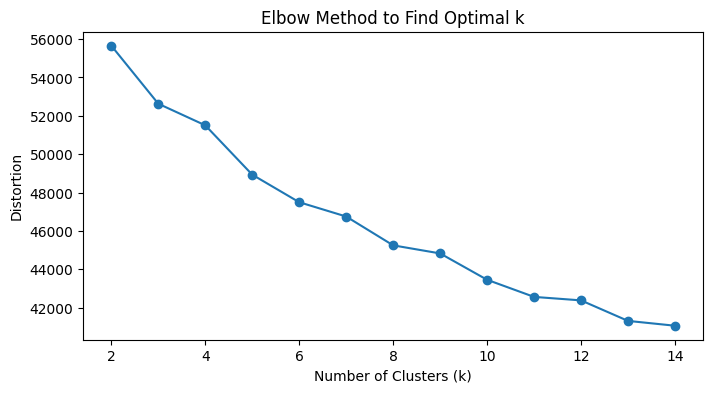

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

distortions = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_minmax_scaled)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method to Find Optimal k')
plt.show()

#Recommendation

In [ ]:
def recommend_anime(user_input, df_animes, kmeans_model, minmax_scaler, features):
    # Process user input into a feature vector
    user_vector = np.hstack([
        np.array([user_input['score']]),
        np.array(user_input['genres_encoded']),
        np.array(user_input['encoded_title_category']),
        np.array(user_input['encoded_aired_decade']),
        np.array(user_input['encoded_episodes'])
    ])

    # Ensure correct shape for scaling
    user_vector = user_vector.reshape(1, -1)

    # Scale user vector using MinMaxScaler
    user_vector_scaled = minmax_scaler.transform(user_vector)

    # Predict cluster for user input
    user_cluster = kmeans_model.predict(user_vector_scaled)[0]

    # Retrieve animes from the same cluster
    cluster_animes = df_animes[kmeans_model.labels_ == user_cluster].copy()

    # Sort by similarity (you can adjust this)
    cluster_animes['similarity'] = cluster_animes.apply(
        lambda row: np.linalg.norm(user_vector_scaled - minmax_scaler.transform(np.hstack([row[f] for f in features]).reshape(1, -1))),
        axis=1
    )
    recommendations = cluster_animes.sort_values(by='similarity', ascending=False).head(5)
    return recommendations[['title', 'score', 'genre', 'aired_year', 'episodes', 'similarity']]

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

optimal_k = 5
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_model.fit(X_minmax_scaled)

KMeans(n_clusters=5, random_state=42)

In [ ]:
import joblib
# Save the trained model and scaler
joblib.dump(kmeans_model, "kmeans_model.pkl")
joblib.dump(minmax_scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
# prompt: show columns as list of df_anime

print(df_animes.columns.tolist())

['uid', 'title', 'genre', 'aired', 'episodes', 'members', 'popularity', 'ranked', 'score', 'episode_category', 'title_category', 'aired_year', 'aired_decade', 'genres_encoded', 'encoded_title_category', 'encoded_aired_decade', 'encoded_episodes']


In [ ]:
df_animes[['genres_encoded', 'encoded_title_category', 'encoded_aired_decade', 'encoded_episodes']].to_csv('anime_encoded.csv', index=False)

# Display the shape of the DataFrame
print(pd.read_csv('anime_encoded.csv').shape)
print(df_animes.shape)

(15472, 4)
(15472, 17)


In [ ]:
user_input = {
    'score': 8.5,
    'genres_encoded': [1, 0, 0, 0, 1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0],
    'encoded_title_category': [0, 1, 0, 0, 0],
    'encoded_aired_decade': [0, 0, 1, 0, 0, 0, 0, 0, 0],
    'encoded_episodes': [1, 0, 0, 0, 0, 0]
}

In [ ]:
features = ['score', 'genres_encoded',
            'encoded_title_category', 'encoded_aired_decade',
            'encoded_episodes']
recommendations = recommend_anime(user_input, df_animes, kmeans_model, minmax_scaler, features)
print("Top 5 Recommendations:")
print(recommendations)

Top 5 Recommendations:
                                  title  score  \
2879        To LOVE-Ru Darkness 2nd OVA   7.69   
3328            To LOVE-Ru Darkness OVA   7.70   
1024   To LOVE-Ru Darkness 2nd Specials   7.74   
10416             Kämpfer für die Liebe   6.57   
7718                      Maken-Ki! OVA   6.74   

                                                   genre  aired_year  \
2879   ['Sci-Fi', 'Harem', 'Comedy', 'Romance', 'Ecch...      2016.0   
3328   ['Sci-Fi', 'Harem', 'Comedy', 'Romance', 'Ecch...      2012.0   
1024   ['Comedy', 'Ecchi', 'Harem', 'Romance', 'Schoo...      2016.0   
10416  ['Action', 'Comedy', 'Ecchi', 'Shoujo Ai', 'Su...      2011.0   
7718   ['Action', 'Ecchi', 'Harem', 'Martial Arts', '...      2012.0   

       episodes  similarity  
2879        3.0    4.244080  
3328        6.0    4.244044  
1024        2.0    4.243907  
10416       2.0    4.131504  
7718        2.0    4.130091  
